<a href="https://colab.research.google.com/github/miqlar/pyconES19_StyleGAN/blob/master/PyconES19_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

!rm -rf sample_data stylegan-encoder
!git clone https://github.com/pbaylies/stylegan-encoder
  
!rm -rf aligned_images raw_images
!mkdir aligned_images raw_images

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 449, done.
remote: Total 449 (delta 0), reused 0 (delta 0), pack-reused 449
Receiving objects: 100% (449/449), 12.52 MiB | 30.30 MiB/s, done.
Resolving deltas: 100% (255/255), done.


**GET IMAGES**

Two options: 

1 - Click the '>' icon in the panel on the top left, upload two images in raw_images folder.

2 - Use code below to capture from webcam.

In [0]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
from datetime import datetime

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(quality=1.0, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))
  
  timestampStr = datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
  filename = 'raw_images/photo_%s.jpeg' %timestampStr
  Image.fromarray(img).save(filename)
  print('Image captured and saved to %s' %filename)
  

In [4]:
img = take_photo() # click the image to capture a frame!

Image captured and saved to raw_images/photo_06-Oct-2019 (12:21:31.774676).jpeg


In [5]:
!python stylegan-encoder/align_images.py raw_images/ aligned_images/ --output_size=1048

Using TensorFlow backend.
64045056/64040097 [==============================] - 2s 0us/step
Aligning trump.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/trump_01.png
Aligning photo_06-Oct-2019 (12:21:31.774676).jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/photo_06-Oct-2019 (12:21:31.774676)_01.png
Aligning photo_06-Oct-2019 (12:21:23.793275).jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/photo_06-Oct-2019 (12:21:23.793275)_01.png
Aligning miquel.JPG ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/miquel_01.png


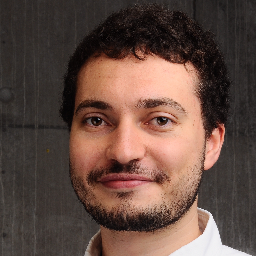

'img 0: miquel_01.png'

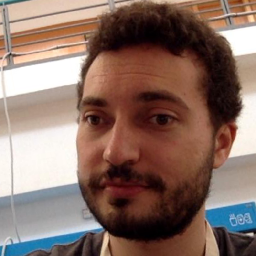

'img 1: photo_06-Oct-2019 (12:21:23.793275)_01.png'

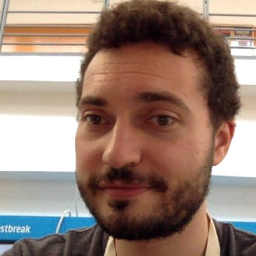

'img 2: photo_06-Oct-2019 (12:21:31.774676)_01.png'

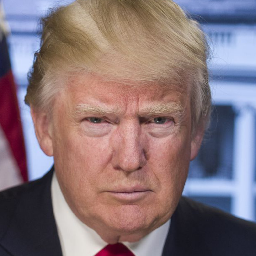

'img 3: trump_01.png'

In [6]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

In [7]:
cd stylegan-encoder

/content/stylegan-encoder


In [8]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf ../generated_images ../latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:01, 199MB/s]


In [9]:
cd ..

/content


In [10]:
!python stylegan-encoder/encode_images.py --batch_size=2 --output_video=True --load_resnet='data/finetuned_resnet.h5' --lr=0.01 --decay_rate=0.8 --iterations=200 --use_l1_penalty=0.3 aligned_images/ generated_images_from_latent/ latent_representations/




Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

2019-10-06 12:24:28.375817: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


58892288/58889256 [==============================] - 1s 0us/step
  0% 0/1 [00:00<?, ?it/s]
  0% 0/200 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan-encoder/encoder/perceptual_model.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.

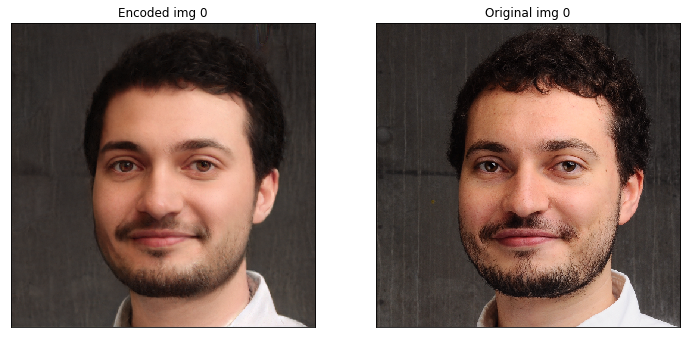

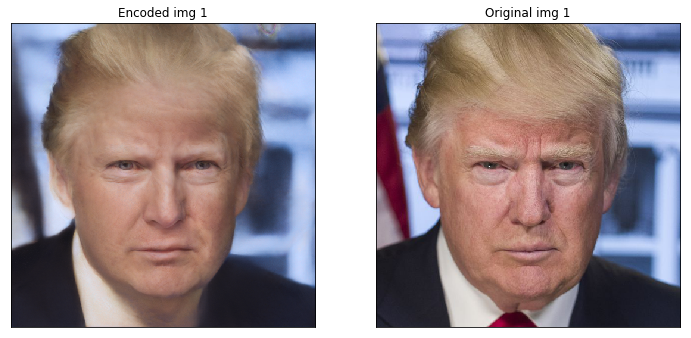

In [11]:
import matplotlib.pyplot as plt

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images_from_latent/', 'aligned_images/', res = 512)

In [0]:
latent_representations = sorted(os.listdir('latent_representations'))

In [0]:
lat_0 = np.load('latent_representations/'+latent_representations[0])
lat_1 = np.load('latent_representations/'+latent_representations[1])

In [0]:
steps = 70
latent_interpolations = []

latent_rep = lat_0

t = lat_1-lat_0
tt = t/steps

for i in range(8):
  latent_interpolations.append(latent_rep)

for i in range(steps):
  latent_rep = latent_rep+tt
  latent_interpolations.append(latent_rep)

for i in range(4):
  latent_interpolations.append(latent_rep)


In [16]:
cd stylegan-encoder

/content/stylegan-encoder


In [17]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = '../cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")






Loading StyleGAN model from ../cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
set_images = []

for i in latent_interpolations:
  w = i.reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  
  #BGR to RGB
  img =  img[...,::-1]
  
  set_images.append(img)
  
set_images.extend(reversed(set_images))

In [20]:
from moviepy.editor import *
import cv2
video_fps = 12
resolution = (1024, 1024)

def make_video(images, vid_name):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(vid_name, fourcc, video_fps, resolution)
    gen = {}
    for img in images:
      video.write(img)
    video.release()
    print('finished '+ vid_name)
    

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1916928/45929032 bytes (4.2%)5734400/45929032 bytes (12.5%)9551872/45929032 bytes (20.8%)13385728/45929032 bytes (29.1%)17137664/45929032 bytes (37.3%)20979712/45929032 bytes (45.7%)24870912/45929032 bytes (54.2%)28794880/45929032 bytes (62.7%)32595968/45929032 bytes (71.0%)36462592/45929032 bytes (79.4%)39993344/45929032 bytes (87.1%)43532288/45929032 bytes (94.8%)

In [21]:
make_video(set_images, '../FACE_TRANSFORMATION.mp4')

finished ../FACE_TRANSFORMATION.mp4


# BELOW IS UNDER CONSTRUCTION

In [0]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

#generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

In [0]:
# Loading already learned latent directions
smile_direction  = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction    = np.load('ffhq_dataset/latent_directions/age.npy')

In [0]:
lat_2 = lat_0 + smile_direction

In [0]:
  i = lat_2
  
  w = i.reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]

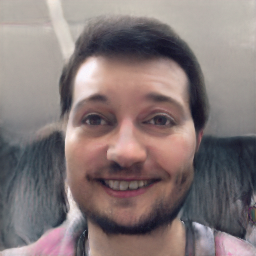

In [60]:
Image.fromarray(img).resize((256,256))